In [1]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import os 
import os.path
import pandas as pd
from mudpy import forward

In [2]:
path = '/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/'

stas = pd.read_csv(path + 'stations.list', delimiter = '\s+')
chans = ['S1', 'S2', 'S3', 'S4']
stas

,Station_name,latitude,longitude,azimuth(S1),azimuth(S2),azimuth(S3),azimuth(S4)
0,KST1,33.5201,135.8363,310,40,85,175
1,HGM1,33.8675,135.7318,337,67,112,202
2,ICU1,33.9001,136.1379,141,231,276,6
3,ANO1,34.7870,136.4019,38,128,173,263
4,SSK1,33.3896,133.3229,355,85,130,220
5,UWA1,33.3859,132.4823,222,312,357,87
6,MUR1,33.2856,134.1563,147,237,282,12
7,MYM1,34.1123,136.1815,237,327,12,102


In [3]:
test = read(path + 'DATA/ANO1.S1')
test[0].stats

         network: 
         station: ANO1
        location: 
         channel: S1
       starttime: 2011-03-11T00:00:00.000000Z
         endtime: 2011-03-11T23:59:59.950000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 1728000
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.05, 'b': 0.0, 'stla': 34.787, 'stlo': 136.4019, 'stel': -426.4905, 'cmpaz': 180.0, 'cmpinc': 90.0, 'nzyear': 2011, 'nzjday': 70, 'nzhour': 0, 'nzmin': 0, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 1728000, 'iftype': 1, 'ievtyp': 40, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kstnm': 'ANO1', 'kevnm': 'Hi-net', 'kcmpnm': 'S1'})

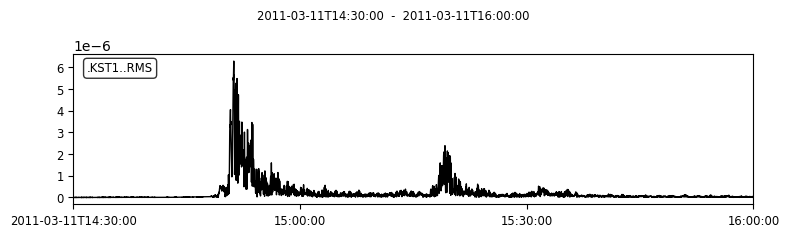

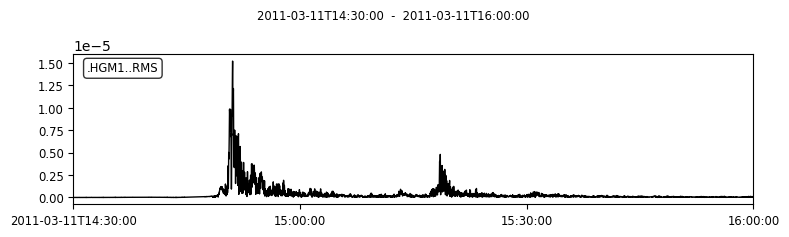

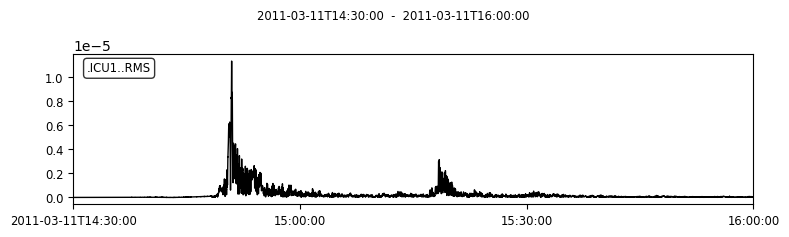

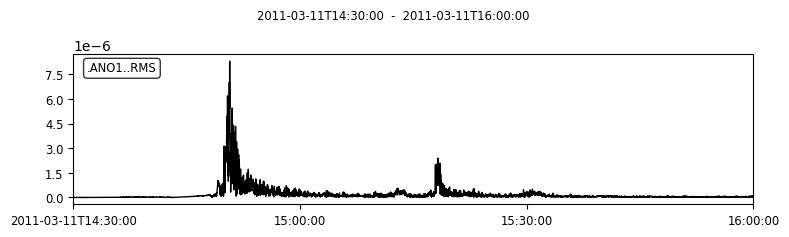

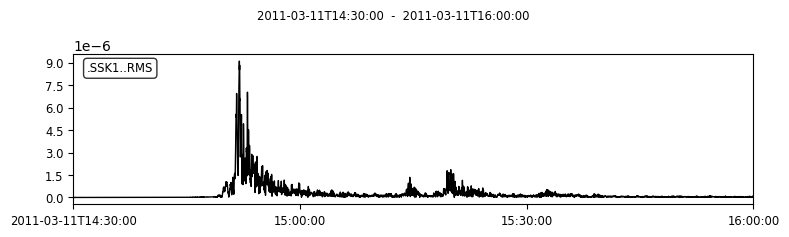

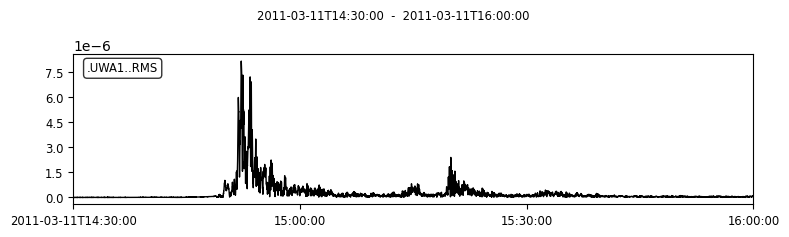

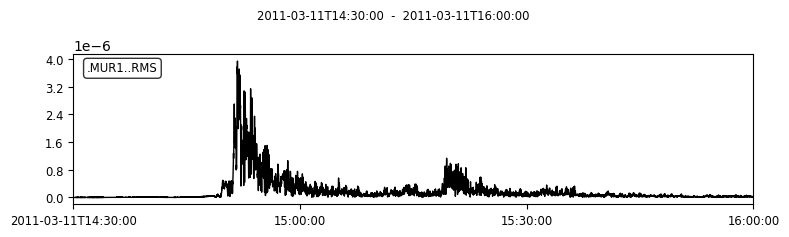

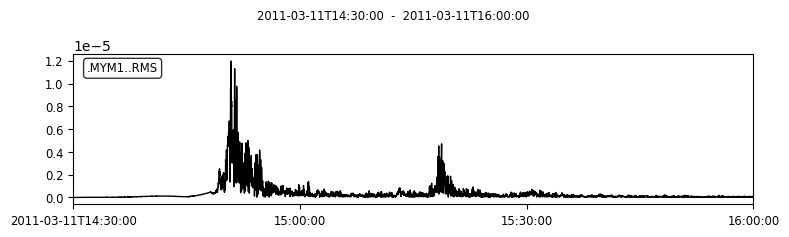

In [7]:
for idx in range(len(stas)):
    
    sta = stas['Station_name'][idx]
    # print(sta)

    S1 = read(path + 'DATA/' + str(sta) + '.S1')
    S2 = read(path + 'DATA/' + str(sta) + '.S2')
    S3 = read(path + 'DATA/' + str(sta) + '.S3')
    # S4 = read(path + 'DATA/' + str(sta) + '.S4')
    
    starttime = UTCDateTime('2011-03-11T14:30:00.000000Z')
    endtime = UTCDateTime('2011-03-11T16:00:00.000000Z')

    S1.trim(starttime, endtime)
    S2.trim(starttime, endtime)
    S3.trim(starttime, endtime)
    S4.trim(starttime, endtime)
    
    # S1.plot()
    # S2.plot()
    # S3.plot()
    # S4.plot()

    # High-pass filter
    corner_period = 1000 # seconds
    corner_freq = 1/corner_period

    filterS1 = S1.copy()
    filterS2 = S2.copy()
    filterS3 = S3.copy()
    # filterS4 = S4.copy()

    filterS1[0].data = forward.highpass(S1[0].data, fcorner = corner_freq, fsample = S1[0].stats.sampling_rate, order = 4)
    filterS2[0].data = forward.highpass(S2[0].data, fcorner = corner_freq, fsample = S2[0].stats.sampling_rate, order = 4)
    filterS3[0].data = forward.highpass(S3[0].data, fcorner = corner_freq, fsample = S3[0].stats.sampling_rate, order = 4)
    # filterS4[0].data = forward.highpass(S4[0].data, fcorner = corner_freq, fsample = S4[0].stats.sampling_rate, order = 4)

    # Detrend
    filterS1[0].data = filterS1[0].data - np.mean(filterS1[0].data[0:50])
    filterS2[0].data = filterS2[0].data - np.mean(filterS2[0].data[0:50])
    filterS3[0].data = filterS3[0].data - np.mean(filterS3[0].data[0:50])
    # filterS4[0].data = filterS4[0].data - np.mean(filterS4[0].data[0:50])

    RMS_strain = np.sqrt(((filterS1[0].data)**2 + (filterS2[0].data)**2 + (filterS3[0].data)**2)/3)         

    times = filterS1[0].times()

    # plt.title(sta)
    # plt.plot(times, S1[0].data, label = 'S1')
    # plt.plot(times, S2[0].data, label = 'S2')
    # plt.plot(times, S3[0].data, label = 'S3')
    # plt.plot(times, S4[0].data, label = 'S4')
    # plt.plot(times, filterS1[0].data, label = 'Filter S1')
    # plt.plot(times, filterS2[0].data, label = 'S2')
    # plt.plot(times, filterS3[0].data, label = 'S3')
    # plt.plot(times, filterS4[0].data, label = 'S4')
    # plt.plot(times, RMS_strain, label = 'RMS')
    # plt.xlim(1000, 1150)
    # plt.ylim(0, max(RMS_strain[1000*20:1150*20])*1.1)
    # plt.ylim(min(S1[0].data[1000*20:1150*20])*0.9, max(S1[0].data[1000*20:1150*20])*1.1)
    # plt.legend()
    # plt.show()

    RMS_st = filterS1.copy()
    RMS_st[0].stats.channel = 'RMS'
    RMS_st[0].data = RMS_strain

    RMS_st[0].plot()
    # print(RMS_st[0].stats)

    # Create folder for the event
    eq_sta_save_dir = path + '3comp_rms/'
    # print(eq_sta_save_dir)
    if os.path.isdir(eq_sta_save_dir):
        pass
    else:
        os.makedirs(eq_sta_save_dir)

    RMS_st.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
